In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import os, shutil, pathlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Hack pro GPU na Windows
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

### Připravíme data

In [3]:
original_dir = pathlib.Path('datasets/08/dogscats/train')
new_base_dir = pathlib.Path('datasets/08/dogscats/small')

In [4]:
train_set = keras.preprocessing.image_dataset_from_directory(
                    new_base_dir / 'train', 
                    image_size=(180, 180),
                    batch_size=32,
                    label_mode='binary')

valid_set = keras.preprocessing.image_dataset_from_directory(
                    new_base_dir / 'valid', 
                    image_size=(180, 180),
                    batch_size=32,
                    label_mode='binary')

test_set = keras.preprocessing.image_dataset_from_directory(
                    new_base_dir / 'test', 
                    image_size=(180, 180),
                    batch_size=32,
                    label_mode='binary')

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


data batch shape: (32, 180, 180, 3)
labels batch shape: (32, 1)


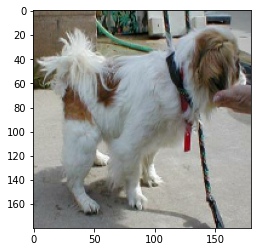

tf.Tensor([1.], shape=(1,), dtype=float32)


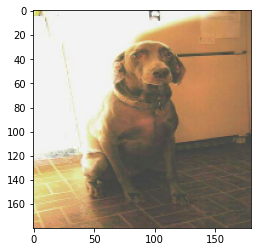

tf.Tensor([1.], shape=(1,), dtype=float32)


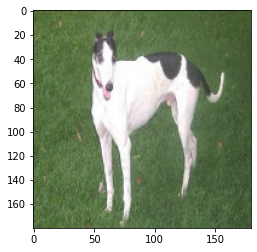

tf.Tensor([1.], shape=(1,), dtype=float32)


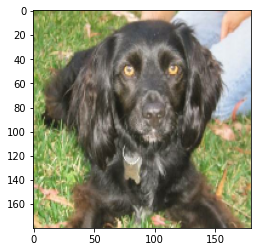

tf.Tensor([1.], shape=(1,), dtype=float32)


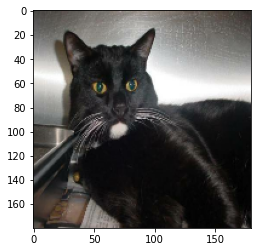

tf.Tensor([0.], shape=(1,), dtype=float32)


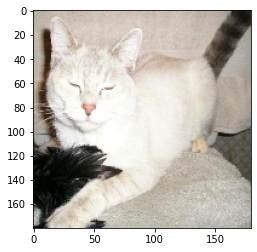

tf.Tensor([0.], shape=(1,), dtype=float32)


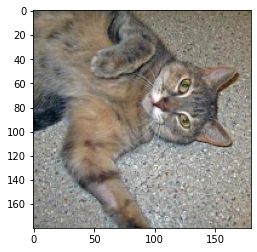

tf.Tensor([0.], shape=(1,), dtype=float32)


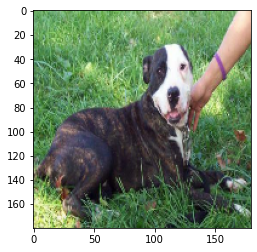

tf.Tensor([1.], shape=(1,), dtype=float32)


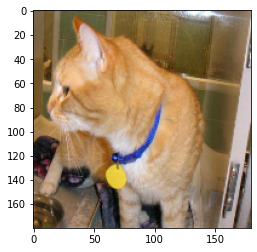

tf.Tensor([0.], shape=(1,), dtype=float32)


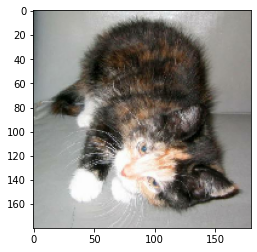

tf.Tensor([0.], shape=(1,), dtype=float32)


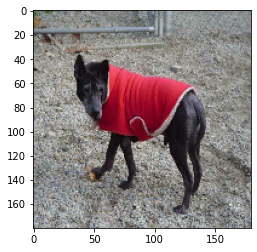

tf.Tensor([1.], shape=(1,), dtype=float32)


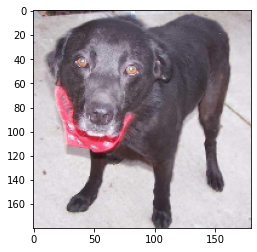

tf.Tensor([1.], shape=(1,), dtype=float32)


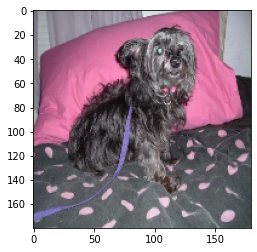

tf.Tensor([1.], shape=(1,), dtype=float32)


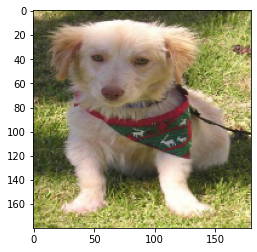

tf.Tensor([1.], shape=(1,), dtype=float32)


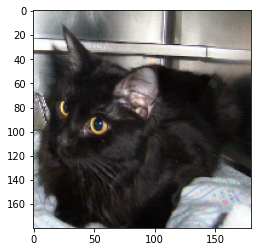

tf.Tensor([0.], shape=(1,), dtype=float32)


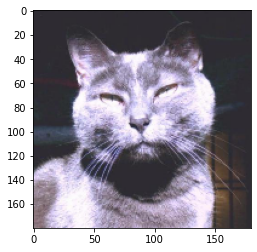

tf.Tensor([0.], shape=(1,), dtype=float32)


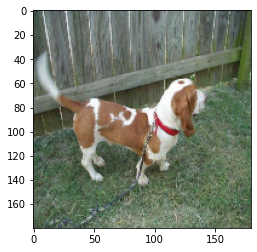

tf.Tensor([1.], shape=(1,), dtype=float32)


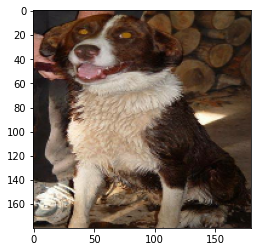

tf.Tensor([1.], shape=(1,), dtype=float32)


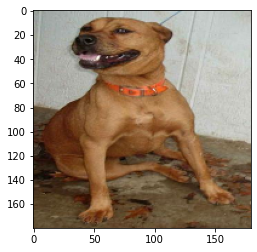

tf.Tensor([1.], shape=(1,), dtype=float32)


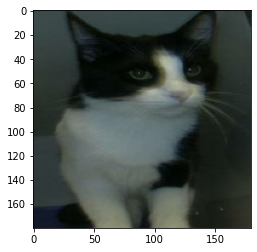

tf.Tensor([0.], shape=(1,), dtype=float32)


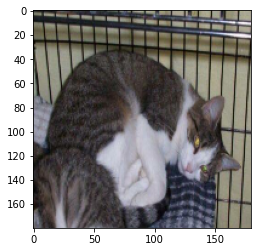

tf.Tensor([0.], shape=(1,), dtype=float32)


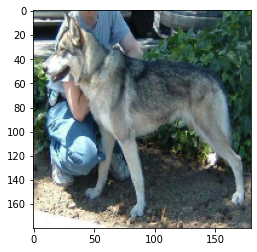

tf.Tensor([1.], shape=(1,), dtype=float32)


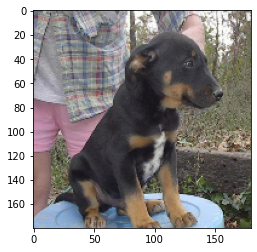

tf.Tensor([1.], shape=(1,), dtype=float32)


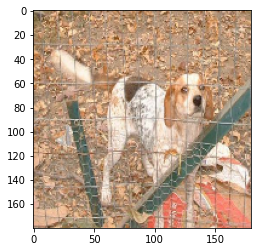

tf.Tensor([1.], shape=(1,), dtype=float32)


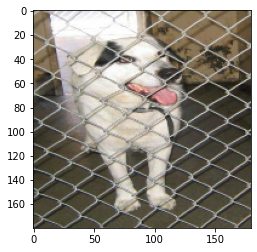

tf.Tensor([1.], shape=(1,), dtype=float32)


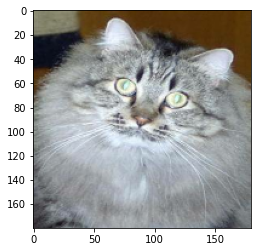

tf.Tensor([0.], shape=(1,), dtype=float32)


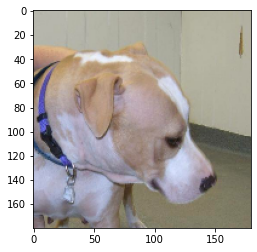

tf.Tensor([1.], shape=(1,), dtype=float32)


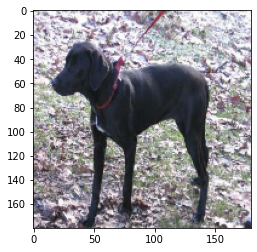

tf.Tensor([1.], shape=(1,), dtype=float32)


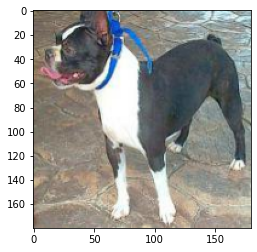

tf.Tensor([1.], shape=(1,), dtype=float32)


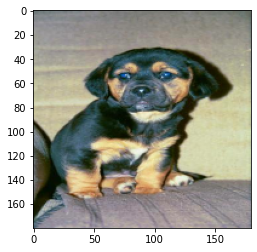

tf.Tensor([1.], shape=(1,), dtype=float32)


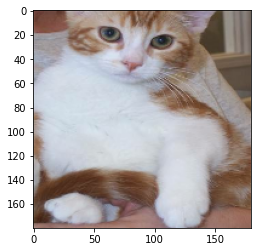

tf.Tensor([0.], shape=(1,), dtype=float32)


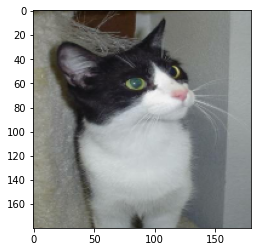

tf.Tensor([0.], shape=(1,), dtype=float32)


In [5]:
for data_batch, labels_batch in train_set:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    
    for image, label in zip(data_batch, labels_batch):
        plt.imshow(image.numpy().astype('uint8'))
        plt.show()
        print(label)
    break

### Načteme předtrénovaný model

In [6]:
conv_base = keras.applications.vgg16.VGG16(weights='imagenet', 
                                           include_top=False,
                                           input_shape=(180, 180, 3))

In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

**Máme dvě možnosti, jak pokračovat: přidat hustě propojené vrstvy, nebo vzít výstupy z konvoluční báze a ty použít pro nový klasifikátor**

### Nový klasifikátor se vstupy z konvoluční báze

Výpočetně velmi nenáročná metoda použitelná i na slabém hardwaru. Průchod konvoluční bází je pro každou instanci jen jeden (což je výpočetně nejnáročnější část).

In [8]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
        
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_set)
valid_features, valid_labels = get_features_and_labels(valid_set)
test_features, test_labels = get_features_and_labels(test_set)

In [9]:
train_features.shape

(2000, 5, 5, 512)

Nachystáme model

In [10]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=train_features.shape[1:]),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid'),
])

In [11]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=20)
checkpoint = keras.callbacks.ModelCheckpoint(
                filepath='08_dogs_pretrained_v1.keras',
                save_best_only=True, monitor='val_loss')


history = model.fit(train_features, train_labels,
                    epochs=20, 
                    validation_data=(valid_features, valid_labels),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/20
63/63 [==============================] - 2s 20ms/step - loss: 19.1130 - accuracy: 0.8455 - val_loss: 0.8192 - val_accuracy: 0.9690
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 0.9443 - accuracy: 0.9670 - val_loss: 0.7634 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 0.3445 - accuracy: 0.9798 - val_loss: 1.1204 - val_accuracy: 0.9660
Epoch 4/20
63/63 [==============================] - 0s 8ms/step - loss: 0.5434 - accuracy: 0.9786 - val_loss: 0.6777 - val_accuracy: 0.9780
Epoch 5/20
63/63 [==============================] - 0s 8ms/step - loss: 0.3608 - accuracy: 0.9859 - val_loss: 0.7861 - val_accuracy: 0.9770
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 0.2748 - accuracy: 0.9926 - val_loss: 0.8441 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 0s 7ms/step - loss: 0.2176 - accuracy: 0.9952 - val_loss: 0.7446 - val_accuracy: 0.9750
Epoch 8/20
63/63 [

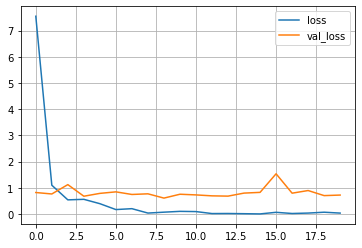

In [12]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

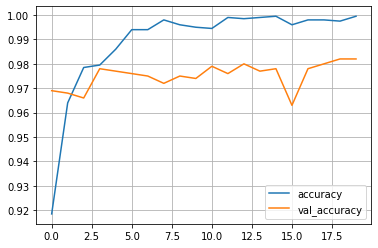

In [13]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.grid(True)

In [14]:
model = keras.models.load_model('08_dogs_pretrained_v1.keras')

In [15]:
model.evaluate(test_features, test_labels)

32/32 [==============================] - 0s 3ms/step - loss: 0.7556 - accuracy: 0.9760


[0.7555744647979736, 0.9760000109672546]

Vidíme výrazné zlepšení na 97 %. Pro další zlepšení by to chtěli zabránit přeučování pomocí data augmentantion. To však v tomto případě nejde použít, protože konvoluční bází data prochází pouze jednou a pak už jsou neměnná. Pokud chceme použít data augmentation, musíme použít celou síť, kdy konvoluční bázi doplníme o hustě propojené vrstvy nahoře. 

### Extrakce příznaků spolu s data augmentation

In [5]:
conv_base = keras.applications.vgg16.VGG16(weights='imagenet',
                                           include_top=False)
conv_base.trainable = False

Musíme zmrazit váhy v konvoluční bázi, protože dense vrstvy jsou na počátku inicializované náhodně. Velké úpravy vah zkraje trénování by tak zničily reprezentace, které jsou natrénované v konvoluční bázi. 

In [6]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               327705

In [8]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
                filepath='08_dogs_pretrained_v2_fix.keras',
                save_best_only=True, monitor='val_loss')


history = model.fit(train_set,
                    epochs=50, 
                    validation_data=valid_set,
                    callbacks=[checkpoint])

Epoch 1/50
63/63 [==============================] - 65s 883ms/step - loss: 34.4992 - accuracy: 0.8306 - val_loss: 14.6917 - val_accuracy: 0.9270
Epoch 2/50
63/63 [==============================] - 30s 468ms/step - loss: 10.0070 - accuracy: 0.9265 - val_loss: 8.7599 - val_accuracy: 0.9560
Epoch 3/50
63/63 [==============================] - 26s 411ms/step - loss: 7.5794 - accuracy: 0.9433 - val_loss: 3.5365 - val_accuracy: 0.9670
Epoch 4/50
63/63 [==============================] - 19s 293ms/step - loss: 5.7061 - accuracy: 0.9518 - val_loss: 4.2704 - val_accuracy: 0.9780
Epoch 5/50
63/63 [==============================] - 15s 234ms/step - loss: 4.4883 - accuracy: 0.9641 - val_loss: 4.5671 - val_accuracy: 0.9740
Epoch 6/50
63/63 [==============================] - 15s 238ms/step - loss: 5.2233 - accuracy: 0.9677 - val_loss: 3.0582 - val_accuracy: 0.9820
Epoch 7/50
63/63 [==============================] - 15s 241ms/step - loss: 1.5298 - accuracy: 0.9845 - val_loss: 3.8507 - val_accuracy: 0.9

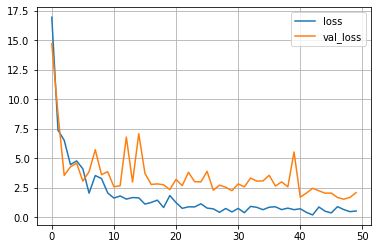

In [9]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

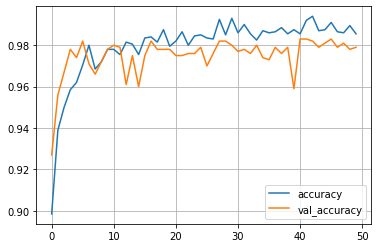

In [10]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.grid(True)

In [11]:
model = keras.models.load_model('08_dogs_pretrained_v2_fix.keras')

In [12]:
model.evaluate(test_set)

32/32 [==============================] - 6s 150ms/step - loss: 2.4655 - accuracy: 0.9720


[2.4655001163482666, 0.972000002861023]

### Jemné doladění modelu

Viz prezentace

Máme zmraženou konvoluční bázi a máme natrénovaný klasifikátor nad ní z minulého modelu. Teď nám stačí rozmrazit horní vrstvy a trénovat znovu.

In [13]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Rozmrazíme horní tři konvoluční vrstvy

In [14]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Musíme také zvolit malou rychlost učení, abychom nepoškodili reprezentace v horních vrstvách konvoluční báze.

In [15]:
model.compile(loss='binary_crossentropy', 
              optimizer=keras.optimizers.RMSprop(lr=1e-5), 
              metrics=['accuracy'])

checkpoint = keras.callbacks.ModelCheckpoint(
                filepath='08_dogs_pretrained_v3_fix.keras',
                save_best_only=True, monitor='val_loss')

history = model.fit(train_set,
                    epochs=50, 
                    validation_data=valid_set,
                    callbacks=[checkpoint])

Epoch 1/50
63/63 [==============================] - 17s 244ms/step - loss: 0.4185 - accuracy: 0.9836 - val_loss: 1.5020 - val_accuracy: 0.9800
Epoch 2/50
63/63 [==============================] - 16s 244ms/step - loss: 0.8450 - accuracy: 0.9879 - val_loss: 1.4971 - val_accuracy: 0.9820
Epoch 3/50
63/63 [==============================] - 16s 251ms/step - loss: 0.6968 - accuracy: 0.9879 - val_loss: 1.4891 - val_accuracy: 0.9820
Epoch 4/50
63/63 [==============================] - 17s 259ms/step - loss: 1.1167 - accuracy: 0.9797 - val_loss: 1.4885 - val_accuracy: 0.9820
Epoch 5/50
63/63 [==============================] - 17s 258ms/step - loss: 0.5860 - accuracy: 0.9838 - val_loss: 1.4852 - val_accuracy: 0.9820
Epoch 6/50
63/63 [==============================] - 16s 247ms/step - loss: 1.0553 - accuracy: 0.9799 - val_loss: 1.4847 - val_accuracy: 0.9810
Epoch 7/50
63/63 [==============================] - 16s 254ms/step - loss: 1.1815 - accuracy: 0.9856 - val_loss: 1.4777 - val_accuracy: 0.9810

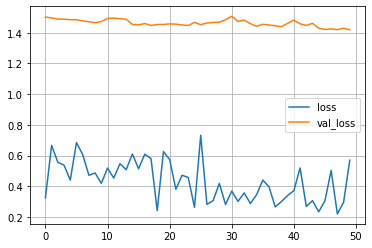

In [16]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

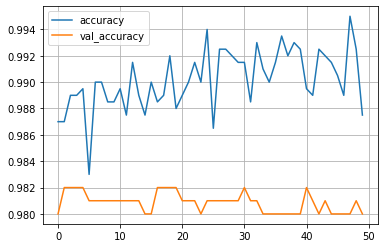

In [17]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.grid(True)

In [19]:
model = keras.models.load_model('08_dogs_pretrained_v3_fix.keras')

In [20]:
model.evaluate(test_set)

32/32 [==============================] - 5s 150ms/step - loss: 2.3205 - accuracy: 0.9730


[2.3204660415649414, 0.9729999899864197]